In [1]:
import torch 
from torch import nn
from torch import FloatTensor
from torch.autograd import Variable
from torch import optim

from numpy.linalg import matrix_rank
from sklearn.datasets import make_spd_matrix
import os
from networkx import nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import SPD
import dataset_tools as dt

# Что хотим тут делать: 

Краткое описание задачи. Имеем [статью](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/download/14825/14321), в которой описан метод, который позволяет работать с положительными симметричными матрицами, а именно отображать их в матрица меньшего размера (что  круто). Сама статья не очень сложная, поэтому попробуем с помошью идей из нее решить некоторую другую задачу.

Например, известно, что кроме матрицы смежностей для графов определяют еще [матрицу Лапласа](https://en.wikipedia.org/wiki/Laplacian_matrix), которая в качестве одного из своих свойств является неотрицательно определенной 

## Маломерное представление для матриц смежности

В качестве первой задачи попробуем сделать некоторое подобие энкодера для графов, у которого в качестве слоев возьмем слои из статьи выше. Эксперименты будем проводить на [датасете](https://figshare.com/articles/MUTAG_and_ENZYMES_DataSet/899875), в котором есть ~200  графов. Обучим самый простой энкодер всего с 4-мя слоями: по два линейных и два SymmetricallyCleanLayer из статьи. 

### Датасет из положительно определённых матриц

Сначала просто для теста сгенерим датасет из положительно определенных матриц и посмотрим на его результаты. 

In [187]:
# учим сетку, возвращаем ее и датасет
coder, dataset = SPD.run_test(n_iterations=1000)


  1%|          | 12/999 [00:01<01:24, 11.62it/s]

EPOCH: 10, TRAIN LOSS: 6.968207359313965, TEST LOSS 8.690054893493652



  2%|▏         | 22/999 [00:01<01:24, 11.55it/s]

EPOCH: 20, TRAIN LOSS: 2.341021776199341, TEST LOSS 2.6160192489624023



  3%|▎         | 32/999 [00:02<01:24, 11.44it/s]

EPOCH: 30, TRAIN LOSS: 1.4044148921966553, TEST LOSS 1.2379708290100098



  4%|▍         | 40/999 [00:03<01:25, 11.19it/s]

EPOCH: 40, TRAIN LOSS: 1.2449212074279785, TEST LOSS 1.1252540349960327



  5%|▌         | 51/999 [00:04<01:28, 10.70it/s]

EPOCH: 50, TRAIN LOSS: 1.174118995666504, TEST LOSS 1.1086227893829346



  6%|▌         | 61/999 [00:05<01:31, 10.26it/s]

EPOCH: 60, TRAIN LOSS: 1.140807032585144, TEST LOSS 1.1053504943847656



  7%|▋         | 71/999 [00:06<01:30, 10.21it/s]

EPOCH: 70, TRAIN LOSS: 1.119438648223877, TEST LOSS 1.1050883531570435



  7%|▋         | 73/999 [00:07<01:32, 10.06it/s]
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  8%|▊         | 82/999 [00:08<01:29, 10.23it/s]

EPOCH: 80, TRAIN LOSS: 1.097057819366455, TEST LOSS 1.1052597761154175


  9%|▉         | 90/999 [00:08<01:29, 10.19it/s]

EPOCH: 90, TRAIN LOSS: 1.0706404447555542, TEST LOSS 1.0951968431472778


 10%|█         | 101/999 [00:09<01:28, 10.16it/s]

EPOCH: 100, TRAIN LOSS: 1.0402038097381592, TEST LOSS 1.0721750259399414


 11%|█         | 111/999 [00:10<01:26, 10.22it/s]

EPOCH: 110, TRAIN LOSS: 1.0018846988677979, TEST LOSS 1.0364058017730713


 12%|█▏        | 121/999 [00:11<01:24, 10.36it/s]

EPOCH: 120, TRAIN LOSS: 0.9751952886581421, TEST LOSS 1.0089508295059204


 13%|█▎        | 131/999 [00:12<01:23, 10.42it/s]

EPOCH: 130, TRAIN LOSS: 0.9579085111618042, TEST LOSS 0.9946497082710266


 14%|█▍        | 141/999 [00:13<01:22, 10.35it/s]

EPOCH: 140, TRAIN LOSS: 0.9389818906784058, TEST LOSS 0.9835097789764404


 15%|█▌        | 151/999 [00:14<01:22, 10.34it/s]

EPOCH: 150, TRAIN LOSS: 0.9207599759101868, TEST LOSS 0.9750453233718872


 16%|█▌        | 161/999 [00:15<01:21, 10.23it/s]

EPOCH: 160, TRAIN LOSS: 0.9022831916809082, TEST LOSS 0.9627546668052673


 17%|█▋        | 171/999 [00:16<01:20, 10.24it/s]

EPOCH: 170, TRAIN LOSS: 0.8818556070327759, TEST LOSS 0.9468567967414856


 18%|█▊        | 181/999 [00:17<01:19, 10.33it/s]

EPOCH: 180, TRAIN LOSS: 0.8600527048110962, TEST LOSS 0.9284488558769226


 19%|█▉        | 191/999 [00:18<01:18, 10.35it/s]

EPOCH: 190, TRAIN LOSS: 0.8371096849441528, TEST LOSS 0.9050159454345703


 20%|██        | 201/999 [00:19<01:16, 10.42it/s]

EPOCH: 200, TRAIN LOSS: 0.8155864477157593, TEST LOSS 0.8808035850524902


 21%|██        | 211/999 [00:20<01:15, 10.48it/s]

EPOCH: 210, TRAIN LOSS: 0.7945561408996582, TEST LOSS 0.8602314591407776


 22%|██▏       | 221/999 [00:20<01:13, 10.53it/s]

EPOCH: 220, TRAIN LOSS: 0.77338045835495, TEST LOSS 0.841893196105957


 23%|██▎       | 231/999 [00:22<01:13, 10.49it/s]

EPOCH: 230, TRAIN LOSS: 0.7513979077339172, TEST LOSS 0.8237003087997437


 24%|██▍       | 242/999 [00:23<01:12, 10.41it/s]

EPOCH: 240, TRAIN LOSS: 0.7281006574630737, TEST LOSS 0.8054870963096619


 25%|██▌       | 252/999 [00:24<01:11, 10.46it/s]

EPOCH: 250, TRAIN LOSS: 0.7027376890182495, TEST LOSS 0.7831583619117737


 26%|██▌       | 260/999 [00:24<01:10, 10.43it/s]

EPOCH: 260, TRAIN LOSS: 0.6744909286499023, TEST LOSS 0.7549208998680115


 27%|██▋       | 272/999 [00:26<01:10, 10.36it/s]

EPOCH: 270, TRAIN LOSS: 0.644681453704834, TEST LOSS 0.7194063067436218


 28%|██▊       | 282/999 [00:27<01:09, 10.37it/s]

EPOCH: 280, TRAIN LOSS: 0.6157381534576416, TEST LOSS 0.6807851791381836


 29%|██▉       | 292/999 [00:28<01:07, 10.41it/s]

EPOCH: 290, TRAIN LOSS: 0.5910767316818237, TEST LOSS 0.6493476033210754


 30%|███       | 302/999 [00:28<01:06, 10.42it/s]

EPOCH: 300, TRAIN LOSS: 0.5682643055915833, TEST LOSS 0.6242988109588623


 31%|███       | 312/999 [00:29<01:05, 10.46it/s]

EPOCH: 310, TRAIN LOSS: 0.5459584593772888, TEST LOSS 0.603882908821106


 32%|███▏      | 322/999 [00:30<01:04, 10.50it/s]

EPOCH: 320, TRAIN LOSS: 0.5239473581314087, TEST LOSS 0.5831701755523682


 33%|███▎      | 332/999 [00:31<01:03, 10.52it/s]

EPOCH: 330, TRAIN LOSS: 0.5008547902107239, TEST LOSS 0.5630534887313843


 34%|███▍      | 342/999 [00:32<01:02, 10.52it/s]

EPOCH: 340, TRAIN LOSS: 0.47753703594207764, TEST LOSS 0.542799711227417


 35%|███▌      | 352/999 [00:33<01:01, 10.54it/s]

EPOCH: 350, TRAIN LOSS: 0.4532957971096039, TEST LOSS 0.5200625658035278


 36%|███▌      | 362/999 [00:34<01:00, 10.58it/s]

EPOCH: 360, TRAIN LOSS: 0.43020886182785034, TEST LOSS 0.4977532923221588


 37%|███▋      | 370/999 [00:34<00:59, 10.59it/s]

EPOCH: 370, TRAIN LOSS: 0.40932437777519226, TEST LOSS 0.47675567865371704


 38%|███▊      | 382/999 [00:36<00:58, 10.58it/s]

EPOCH: 380, TRAIN LOSS: 0.3919260799884796, TEST LOSS 0.46117103099823


 39%|███▉      | 392/999 [00:37<00:57, 10.59it/s]

EPOCH: 390, TRAIN LOSS: 0.376848042011261, TEST LOSS 0.4479031562805176


 40%|████      | 402/999 [00:37<00:56, 10.63it/s]

EPOCH: 400, TRAIN LOSS: 0.36309459805488586, TEST LOSS 0.43634364008903503


 41%|████      | 412/999 [00:38<00:55, 10.60it/s]

EPOCH: 410, TRAIN LOSS: 0.35072094202041626, TEST LOSS 0.4279869496822357


 42%|████▏     | 422/999 [00:39<00:54, 10.61it/s]

EPOCH: 420, TRAIN LOSS: 0.33966511487960815, TEST LOSS 0.4205702543258667


 43%|████▎     | 432/999 [00:40<00:53, 10.63it/s]

EPOCH: 430, TRAIN LOSS: 0.32970428466796875, TEST LOSS 0.4144282639026642


 44%|████▍     | 442/999 [00:41<00:52, 10.67it/s]

EPOCH: 440, TRAIN LOSS: 0.3210178315639496, TEST LOSS 0.40911248326301575


 45%|████▌     | 452/999 [00:42<00:51, 10.68it/s]

EPOCH: 450, TRAIN LOSS: 0.313498318195343, TEST LOSS 0.4042074978351593


 46%|████▌     | 462/999 [00:43<00:50, 10.72it/s]

EPOCH: 460, TRAIN LOSS: 0.3064330518245697, TEST LOSS 0.4002317786216736


 47%|████▋     | 472/999 [00:43<00:48, 10.76it/s]

EPOCH: 470, TRAIN LOSS: 0.30021706223487854, TEST LOSS 0.3970071077346802


 48%|████▊     | 482/999 [00:44<00:47, 10.80it/s]

EPOCH: 480, TRAIN LOSS: 0.2947506606578827, TEST LOSS 0.3945746421813965


 49%|████▉     | 492/999 [00:45<00:46, 10.82it/s]

EPOCH: 490, TRAIN LOSS: 0.290019690990448, TEST LOSS 0.39277124404907227


 50%|█████     | 500/999 [00:46<00:46, 10.84it/s]

EPOCH: 500, TRAIN LOSS: 0.28606343269348145, TEST LOSS 0.3914687931537628


 51%|█████▏    | 512/999 [00:47<00:44, 10.86it/s]

EPOCH: 510, TRAIN LOSS: 0.2828051745891571, TEST LOSS 0.3904089033603668


 52%|█████▏    | 520/999 [00:47<00:44, 10.88it/s]

EPOCH: 520, TRAIN LOSS: 0.2801343500614166, TEST LOSS 0.38960394263267517


 53%|█████▎    | 532/999 [00:48<00:42, 10.89it/s]

EPOCH: 530, TRAIN LOSS: 0.27786290645599365, TEST LOSS 0.38878029584884644


 54%|█████▍    | 542/999 [00:49<00:41, 10.91it/s]

EPOCH: 540, TRAIN LOSS: 0.27581286430358887, TEST LOSS 0.38791623711586


 55%|█████▌    | 552/999 [00:50<00:40, 10.93it/s]

EPOCH: 550, TRAIN LOSS: 0.2740107476711273, TEST LOSS 0.38689884543418884


 56%|█████▋    | 562/999 [00:51<00:40, 10.92it/s]

EPOCH: 560, TRAIN LOSS: 0.27241870760917664, TEST LOSS 0.38578611612319946


 57%|█████▋    | 572/999 [00:52<00:39, 10.93it/s]

EPOCH: 570, TRAIN LOSS: 0.27096718549728394, TEST LOSS 0.38464629650115967


 58%|█████▊    | 582/999 [00:53<00:38, 10.94it/s]

EPOCH: 580, TRAIN LOSS: 0.26960596442222595, TEST LOSS 0.3834735155105591


 59%|█████▉    | 592/999 [00:54<00:37, 10.95it/s]

EPOCH: 590, TRAIN LOSS: 0.2683123052120209, TEST LOSS 0.38238564133644104


 60%|██████    | 602/999 [00:55<00:36, 10.94it/s]

EPOCH: 600, TRAIN LOSS: 0.26707711815834045, TEST LOSS 0.3811727464199066


 61%|██████▏   | 612/999 [00:55<00:35, 10.97it/s]

EPOCH: 610, TRAIN LOSS: 0.26590651273727417, TEST LOSS 0.3799596130847931


 62%|██████▏   | 622/999 [00:56<00:34, 11.00it/s]

EPOCH: 620, TRAIN LOSS: 0.2647686004638672, TEST LOSS 0.37864622473716736


 63%|██████▎   | 632/999 [00:57<00:33, 11.02it/s]

EPOCH: 630, TRAIN LOSS: 0.26363107562065125, TEST LOSS 0.37736016511917114


 64%|██████▍   | 642/999 [00:58<00:32, 11.03it/s]

EPOCH: 640, TRAIN LOSS: 0.26247379183769226, TEST LOSS 0.37601345777511597


 65%|██████▌   | 652/999 [00:58<00:31, 11.06it/s]

EPOCH: 650, TRAIN LOSS: 0.2612477242946625, TEST LOSS 0.374494343996048


 66%|██████▋   | 662/999 [00:59<00:30, 11.08it/s]

EPOCH: 660, TRAIN LOSS: 0.2600168287754059, TEST LOSS 0.37287259101867676


 67%|██████▋   | 670/999 [01:00<00:29, 11.10it/s]

EPOCH: 670, TRAIN LOSS: 0.25879156589508057, TEST LOSS 0.3712191581726074


 68%|██████▊   | 682/999 [01:01<00:28, 11.11it/s]

EPOCH: 680, TRAIN LOSS: 0.25753113627433777, TEST LOSS 0.3695200979709625


 69%|██████▉   | 692/999 [01:02<00:27, 11.13it/s]

EPOCH: 690, TRAIN LOSS: 0.25619906187057495, TEST LOSS 0.3678280711174011


 70%|███████   | 702/999 [01:03<00:26, 11.13it/s]

EPOCH: 700, TRAIN LOSS: 0.25483667850494385, TEST LOSS 0.366073340177536


 71%|███████▏  | 712/999 [01:04<00:25, 11.12it/s]

EPOCH: 710, TRAIN LOSS: 0.2533820867538452, TEST LOSS 0.3641358017921448


 72%|███████▏  | 721/999 [01:04<00:25, 11.10it/s]

EPOCH: 720, TRAIN LOSS: 0.25186705589294434, TEST LOSS 0.3622240424156189


 73%|███████▎  | 731/999 [01:05<00:24, 11.10it/s]

EPOCH: 730, TRAIN LOSS: 0.25027212500572205, TEST LOSS 0.36020535230636597


 74%|███████▍  | 741/999 [01:06<00:23, 11.09it/s]

EPOCH: 740, TRAIN LOSS: 0.2486053705215454, TEST LOSS 0.3577384948730469


 75%|███████▌  | 751/999 [01:07<00:22, 11.07it/s]

EPOCH: 750, TRAIN LOSS: 0.24686041474342346, TEST LOSS 0.3550771474838257


 76%|███████▌  | 761/999 [01:08<00:21, 11.07it/s]

EPOCH: 760, TRAIN LOSS: 0.24501803517341614, TEST LOSS 0.3521961271762848


 77%|███████▋  | 771/999 [01:09<00:20, 11.05it/s]

EPOCH: 770, TRAIN LOSS: 0.24306116998195648, TEST LOSS 0.34909093379974365


 78%|███████▊  | 781/999 [01:10<00:19, 11.03it/s]

EPOCH: 780, TRAIN LOSS: 0.24097806215286255, TEST LOSS 0.3455047607421875


 79%|███████▉  | 792/999 [01:12<00:18, 10.99it/s]

EPOCH: 790, TRAIN LOSS: 0.23875373601913452, TEST LOSS 0.3413948118686676


 80%|████████  | 801/999 [01:12<00:18, 10.98it/s]

EPOCH: 800, TRAIN LOSS: 0.23637869954109192, TEST LOSS 0.3368360698223114


 81%|████████  | 811/999 [01:13<00:17, 10.97it/s]

EPOCH: 810, TRAIN LOSS: 0.23384152352809906, TEST LOSS 0.3317544162273407


 82%|████████▏ | 821/999 [01:14<00:16, 10.96it/s]

EPOCH: 820, TRAIN LOSS: 0.23115096986293793, TEST LOSS 0.3262110650539398


 83%|████████▎ | 832/999 [01:16<00:15, 10.93it/s]

EPOCH: 830, TRAIN LOSS: 0.22831961512565613, TEST LOSS 0.3201711177825928


 84%|████████▍ | 841/999 [01:17<00:14, 10.91it/s]

EPOCH: 840, TRAIN LOSS: 0.22535930573940277, TEST LOSS 0.3135351538658142


 85%|████████▌ | 851/999 [01:17<00:13, 10.92it/s]

EPOCH: 850, TRAIN LOSS: 0.22225700318813324, TEST LOSS 0.30645814538002014


 86%|████████▌ | 861/999 [01:18<00:12, 10.90it/s]

EPOCH: 860, TRAIN LOSS: 0.2190544307231903, TEST LOSS 0.2989732325077057


 87%|████████▋ | 872/999 [01:20<00:11, 10.89it/s]

EPOCH: 870, TRAIN LOSS: 0.21580001711845398, TEST LOSS 0.29105526208877563


 88%|████████▊ | 881/999 [01:21<00:10, 10.86it/s]

EPOCH: 880, TRAIN LOSS: 0.21252332627773285, TEST LOSS 0.2828589081764221


 89%|████████▉ | 891/999 [01:22<00:09, 10.86it/s]

EPOCH: 890, TRAIN LOSS: 0.20925837755203247, TEST LOSS 0.274495393037796


 90%|█████████ | 900/999 [01:23<00:09, 10.84it/s]

EPOCH: 900, TRAIN LOSS: 0.20605264604091644, TEST LOSS 0.26626259088516235


 91%|█████████ | 911/999 [01:24<00:08, 10.83it/s]

EPOCH: 910, TRAIN LOSS: 0.20291344821453094, TEST LOSS 0.25824427604675293


 92%|█████████▏| 921/999 [01:25<00:07, 10.82it/s]

EPOCH: 920, TRAIN LOSS: 0.19982409477233887, TEST LOSS 0.25048592686653137


 93%|█████████▎| 932/999 [01:26<00:06, 10.80it/s]

EPOCH: 930, TRAIN LOSS: 0.19680476188659668, TEST LOSS 0.24297714233398438


 94%|█████████▍| 942/999 [01:27<00:05, 10.78it/s]

EPOCH: 940, TRAIN LOSS: 0.19389823079109192, TEST LOSS 0.23559673130512238


 95%|█████████▌| 952/999 [01:28<00:04, 10.78it/s]

EPOCH: 950, TRAIN LOSS: 0.1911197006702423, TEST LOSS 0.22859683632850647


 96%|█████████▋| 962/999 [01:29<00:03, 10.78it/s]

EPOCH: 960, TRAIN LOSS: 0.1884855180978775, TEST LOSS 0.22202636301517487


 97%|█████████▋| 971/999 [01:30<00:02, 10.77it/s]

EPOCH: 970, TRAIN LOSS: 0.18602560460567474, TEST LOSS 0.21582242846488953


 98%|█████████▊| 981/999 [01:31<00:01, 10.74it/s]

EPOCH: 980, TRAIN LOSS: 0.18375475704669952, TEST LOSS 0.20998935401439667


 99%|█████████▉| 991/999 [01:32<00:00, 10.73it/s]

EPOCH: 990, TRAIN LOSS: 0.18164803087711334, TEST LOSS 0.2044777125120163


100%|██████████| 999/999 [01:33<00:00, 10.72it/s]


In [190]:
print("Результат применения нашей модели к произвольной матрице\n", coder(dataset)[0])
print("Сама матрица\n", dataset[0])

Результат применения нашей модели к произвольной матрице
 Variable containing:
 1.1597 -1.2545  0.2238 -1.3226 -0.8728 -0.5074
-1.2545  1.8764 -0.3922  1.6513  0.9479  0.4915
 0.2238 -0.3922  0.3590 -0.5085 -0.3040 -0.0251
-1.3226  1.6513 -0.5085  2.5638  1.1053  0.3887
-0.8728  0.9479 -0.3040  1.1053  1.4248  0.0865
-0.5074  0.4915 -0.0251  0.3887  0.0865  0.3594
[torch.FloatTensor of size 6x6]

Сама матрица
 Variable containing:
 1.6538 -1.6044  0.2423 -1.5757 -0.8835 -0.0873
-1.6044  2.3821 -0.3803  2.0151  1.1325  0.0097
 0.2423 -0.3803  0.3766 -0.4845 -0.2825 -0.0868
-1.5757  2.0151 -0.4845  2.5606  1.0514  0.2524
-0.8835  1.1325 -0.2825  1.0514  1.3400  0.0003
-0.0873  0.0097 -0.0868  0.2524  0.0003  0.3175
[torch.FloatTensor of size 6x6]



Работает вполне неплохо, что и ожидалось 

### Mutag датасет

Тут пробуем нашу модель на графовом датасете. Для каждого графа считаем его матрицу лапласа и кладем ее в выборку, потом на этом деле снова начинаем учить сетку. 

In [193]:
coder, dataset = SPD.run_test_mutag(n_iterations=500)

  2%|▏         | 11/499 [00:02<01:28,  5.49it/s]

EPOCH: 10, TRAIN LOSS: 0.19712954759597778, TEST LOSS 0.14197520911693573


  4%|▍         | 21/499 [00:03<01:29,  5.32it/s]

EPOCH: 20, TRAIN LOSS: 0.14037972688674927, TEST LOSS 0.12351789325475693


  6%|▌         | 30/499 [00:05<01:27,  5.35it/s]

EPOCH: 30, TRAIN LOSS: 0.127322718501091, TEST LOSS 0.11167646944522858


  8%|▊         | 41/499 [00:07<01:27,  5.25it/s]

EPOCH: 40, TRAIN LOSS: 0.11849711835384369, TEST LOSS 0.1044565960764885


 10%|█         | 51/499 [00:09<01:24,  5.27it/s]

EPOCH: 50, TRAIN LOSS: 0.11534447222948074, TEST LOSS 0.10198447108268738


 12%|█▏        | 61/499 [00:11<01:23,  5.28it/s]

EPOCH: 60, TRAIN LOSS: 0.11363948881626129, TEST LOSS 0.10063354671001434


 14%|█▍        | 71/499 [00:13<01:20,  5.33it/s]

EPOCH: 70, TRAIN LOSS: 0.11213558167219162, TEST LOSS 0.09911224246025085


 16%|█▌        | 81/499 [00:15<01:18,  5.35it/s]

EPOCH: 80, TRAIN LOSS: 0.11067698895931244, TEST LOSS 0.09766237437725067


 18%|█▊        | 91/499 [00:17<01:16,  5.35it/s]

EPOCH: 90, TRAIN LOSS: 0.10889769345521927, TEST LOSS 0.0962556004524231


 20%|██        | 101/499 [00:18<01:14,  5.36it/s]

EPOCH: 100, TRAIN LOSS: 0.10659370571374893, TEST LOSS 0.09432914108037949


 22%|██▏       | 111/499 [00:20<01:12,  5.37it/s]

EPOCH: 110, TRAIN LOSS: 0.10393054038286209, TEST LOSS 0.0922497883439064


 24%|██▍       | 121/499 [00:22<01:10,  5.39it/s]

EPOCH: 120, TRAIN LOSS: 0.10133963823318481, TEST LOSS 0.08909841626882553


 26%|██▋       | 131/499 [00:24<01:07,  5.41it/s]

EPOCH: 130, TRAIN LOSS: 0.09909091144800186, TEST LOSS 0.08707249909639359


 28%|██▊       | 141/499 [00:26<01:06,  5.42it/s]

EPOCH: 140, TRAIN LOSS: 0.0968422219157219, TEST LOSS 0.0854298546910286


 30%|███       | 151/499 [00:27<01:04,  5.43it/s]

EPOCH: 150, TRAIN LOSS: 0.09379082173109055, TEST LOSS 0.0823960155248642


 32%|███▏      | 161/499 [00:29<01:02,  5.45it/s]

EPOCH: 160, TRAIN LOSS: 0.0889708399772644, TEST LOSS 0.07758042961359024


 34%|███▍      | 171/499 [00:31<01:00,  5.45it/s]

EPOCH: 170, TRAIN LOSS: 0.0828920304775238, TEST LOSS 0.07190632075071335


 36%|███▋      | 181/499 [00:33<00:58,  5.42it/s]

EPOCH: 180, TRAIN LOSS: 0.07788261026144028, TEST LOSS 0.06751977652311325


 38%|███▊      | 191/499 [00:35<00:56,  5.44it/s]

EPOCH: 190, TRAIN LOSS: 0.07396620512008667, TEST LOSS 0.06443893909454346


 40%|████      | 201/499 [00:36<00:54,  5.44it/s]

EPOCH: 200, TRAIN LOSS: 0.0702691301703453, TEST LOSS 0.06176358088850975


 42%|████▏     | 211/499 [00:38<00:53,  5.43it/s]

EPOCH: 210, TRAIN LOSS: 0.06590130925178528, TEST LOSS 0.05924762412905693


 44%|████▍     | 220/499 [00:41<00:52,  5.29it/s]

EPOCH: 220, TRAIN LOSS: 0.0626073107123375, TEST LOSS 0.05728299170732498


 46%|████▋     | 231/499 [00:43<00:50,  5.27it/s]

EPOCH: 230, TRAIN LOSS: 0.06048348546028137, TEST LOSS 0.055967047810554504


 48%|████▊     | 240/499 [00:45<00:49,  5.25it/s]

EPOCH: 240, TRAIN LOSS: 0.0583941787481308, TEST LOSS 0.05473392456769943


 50%|█████     | 250/499 [00:47<00:47,  5.24it/s]

EPOCH: 250, TRAIN LOSS: 0.05624337121844292, TEST LOSS 0.05337804555892944


 52%|█████▏    | 261/499 [00:50<00:45,  5.22it/s]

EPOCH: 260, TRAIN LOSS: 0.053436532616615295, TEST LOSS 0.051445819437503815


 54%|█████▍    | 270/499 [00:52<00:44,  5.19it/s]

EPOCH: 270, TRAIN LOSS: 0.051017891615629196, TEST LOSS 0.04970152676105499


 56%|█████▌    | 280/499 [00:54<00:42,  5.16it/s]

EPOCH: 280, TRAIN LOSS: 0.04926129803061485, TEST LOSS 0.048522159457206726


 58%|█████▊    | 291/499 [00:56<00:40,  5.16it/s]

EPOCH: 290, TRAIN LOSS: 0.04794570803642273, TEST LOSS 0.047715023159980774


 60%|██████    | 301/499 [00:58<00:38,  5.16it/s]

EPOCH: 300, TRAIN LOSS: 0.046789806336164474, TEST LOSS 0.04697312042117119


 62%|██████▏   | 311/499 [01:00<00:36,  5.11it/s]

EPOCH: 310, TRAIN LOSS: 0.04569118842482567, TEST LOSS 0.046245116740465164


 64%|██████▍   | 321/499 [01:02<00:34,  5.12it/s]

EPOCH: 320, TRAIN LOSS: 0.04464269056916237, TEST LOSS 0.045528557151556015


 66%|██████▋   | 331/499 [01:04<00:32,  5.14it/s]

EPOCH: 330, TRAIN LOSS: 0.043658193200826645, TEST LOSS 0.0448172353208065


 68%|██████▊   | 341/499 [01:06<00:30,  5.15it/s]

EPOCH: 340, TRAIN LOSS: 0.04271497204899788, TEST LOSS 0.04410538449883461


 70%|███████   | 351/499 [01:07<00:28,  5.16it/s]

EPOCH: 350, TRAIN LOSS: 0.04161064699292183, TEST LOSS 0.04310958832502365


 72%|███████▏  | 361/499 [01:09<00:26,  5.17it/s]

EPOCH: 360, TRAIN LOSS: 0.04047416150569916, TEST LOSS 0.04213237389922142


 74%|███████▍  | 371/499 [01:11<00:24,  5.18it/s]

EPOCH: 370, TRAIN LOSS: 0.03930344432592392, TEST LOSS 0.04111156240105629


 76%|███████▋  | 381/499 [01:13<00:22,  5.20it/s]

EPOCH: 380, TRAIN LOSS: 0.0379781648516655, TEST LOSS 0.039856504648923874


 78%|███████▊  | 391/499 [01:15<00:20,  5.21it/s]

EPOCH: 390, TRAIN LOSS: 0.03662174195051193, TEST LOSS 0.03844829648733139


 80%|████████  | 400/499 [01:16<00:19,  5.20it/s]

EPOCH: 400, TRAIN LOSS: 0.034548625349998474, TEST LOSS 0.03631008788943291


 82%|████████▏ | 411/499 [01:19<00:16,  5.20it/s]

EPOCH: 410, TRAIN LOSS: 0.032528914511203766, TEST LOSS 0.034469470381736755


 84%|████████▍ | 421/499 [01:20<00:14,  5.21it/s]

EPOCH: 420, TRAIN LOSS: 0.030917072668671608, TEST LOSS 0.03305266797542572


 86%|████████▋ | 431/499 [01:22<00:13,  5.21it/s]

EPOCH: 430, TRAIN LOSS: 0.02959536574780941, TEST LOSS 0.03154238313436508


 88%|████████▊ | 441/499 [01:24<00:11,  5.22it/s]

EPOCH: 440, TRAIN LOSS: 0.028693348169326782, TEST LOSS 0.03057944029569626


 90%|█████████ | 451/499 [01:26<00:09,  5.23it/s]

EPOCH: 450, TRAIN LOSS: 0.028074275702238083, TEST LOSS 0.029863033443689346


 92%|█████████▏| 461/499 [01:28<00:07,  5.24it/s]

EPOCH: 460, TRAIN LOSS: 0.027620680630207062, TEST LOSS 0.02927342988550663


 94%|█████████▍| 470/499 [01:29<00:05,  5.25it/s]

EPOCH: 470, TRAIN LOSS: 0.027228673920035362, TEST LOSS 0.02875402756035328


 96%|█████████▋| 481/499 [01:31<00:03,  5.26it/s]

EPOCH: 480, TRAIN LOSS: 0.026817919686436653, TEST LOSS 0.02820870466530323


 98%|█████████▊| 491/499 [01:33<00:01,  5.27it/s]

EPOCH: 490, TRAIN LOSS: 0.026432575657963753, TEST LOSS 0.027644818648695946


100%|██████████| 499/499 [01:34<00:00,  5.28it/s]


In [197]:
print("Результат применения нашей модели к матрице построенной по графу\n", coder(dataset)[9].round())
print("Сама матрица\n", dataset[9])

Результат применения нашей модели к матрице построенной по графу
 Variable containing:
 0  1 -0  0 -0  0
 1 -0  1  0  0 -0
-0  1 -0  0  0  1
 0  0  0 -0 -0  0
-0  0  0 -0 -0  1
 0 -0  1  0  1  0
[torch.FloatTensor of size 6x6]

Сама матрица
 Variable containing:
 0  1  0  0  0  0
 1  0  1  0  0  0
 0  1  0  0  0  1
 0  0  0  0  0  0
 0  0  0  0  0  1
 0  0  1  0  1  0
[torch.FloatTensor of size 6x6]



Отрабатывает тоже вполне неплохо. Пробовал изначально сворачивать матрицу лапласа, которую считали для графа, но качество получилось плохим. Поэтому сейчас сетка работает сразу на матрицах смежностей, не особо задумываясь о том, что она может быть не положительно определенной. 

Отрисуем пару получившихся графов. 

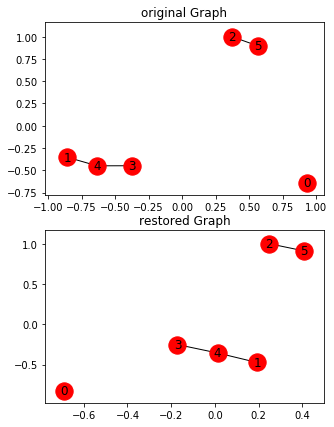

In [241]:
dt.draw_graphs(10, dataset, coder)

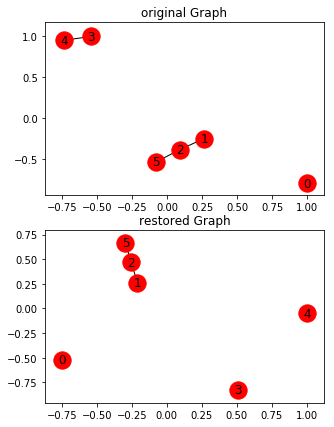

In [246]:
dt.draw_graphs(15, dataset, coder)

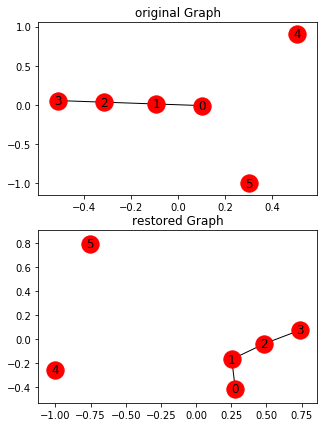

In [245]:
dt.draw_graphs(100, dataset, coder)

In [318]:
# свернем пару графов и посмотрим на их эмбеддинги 
A = coder.encoder(dataset[100].unsqueeze(0))
B = coder.encoder(dataset[4].unsqueeze(0))

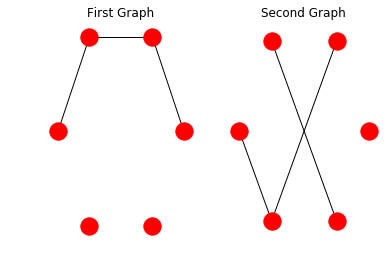

In [343]:
fig, ax = plt.subplots(ncols=2, nrows=1)
dt.draw_graph(coder.decoder(A).round(), ax=ax[0])
ax[0].set_title("First Graph")
dt.draw_graph(coder.decoder(B).round(), ax=ax[1])
ax[1].set_title("Second Graph")
plt.legend()

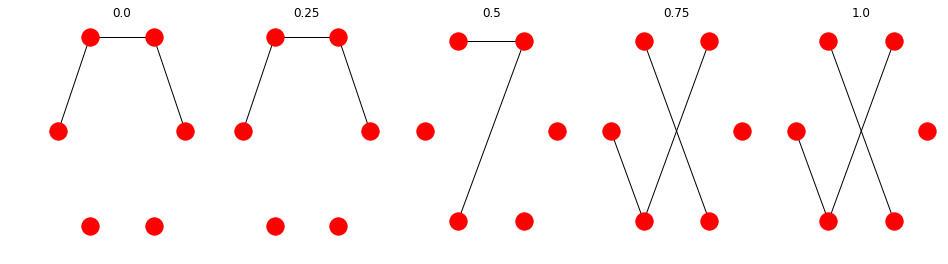

In [375]:
n_points = 5
fig = plt.figure(figsize=(16, 4))
for i, t in enumerate(np.linspace(0, 1, n_points)):
    C_t = A - (A-B)*t
    GC_t = coder.decoder(C_t).round()
    ax = fig.add_subplot(1,n_points,i+1)
    dt.draw_graph(GC_t, ax)
    ax.set_title(round(t, 2))
    ax.plot()

In [379]:
A.view(-1, 25)

Variable containing:

Columns 0 to 9 
 0.0000  0.0691  0.1161  0.0658  0.0131  0.0691  0.2820  0.7631  1.5039  0.1514

Columns 10 to 19 
 0.1161  0.7631  1.2566  0.9736  0.2323  0.0658  1.5039  0.9736  0.1617  0.3421

Columns 20 to 24 
 0.0131  0.1514  0.2323  0.3421  0.0497
[torch.FloatTensor of size 1x25]